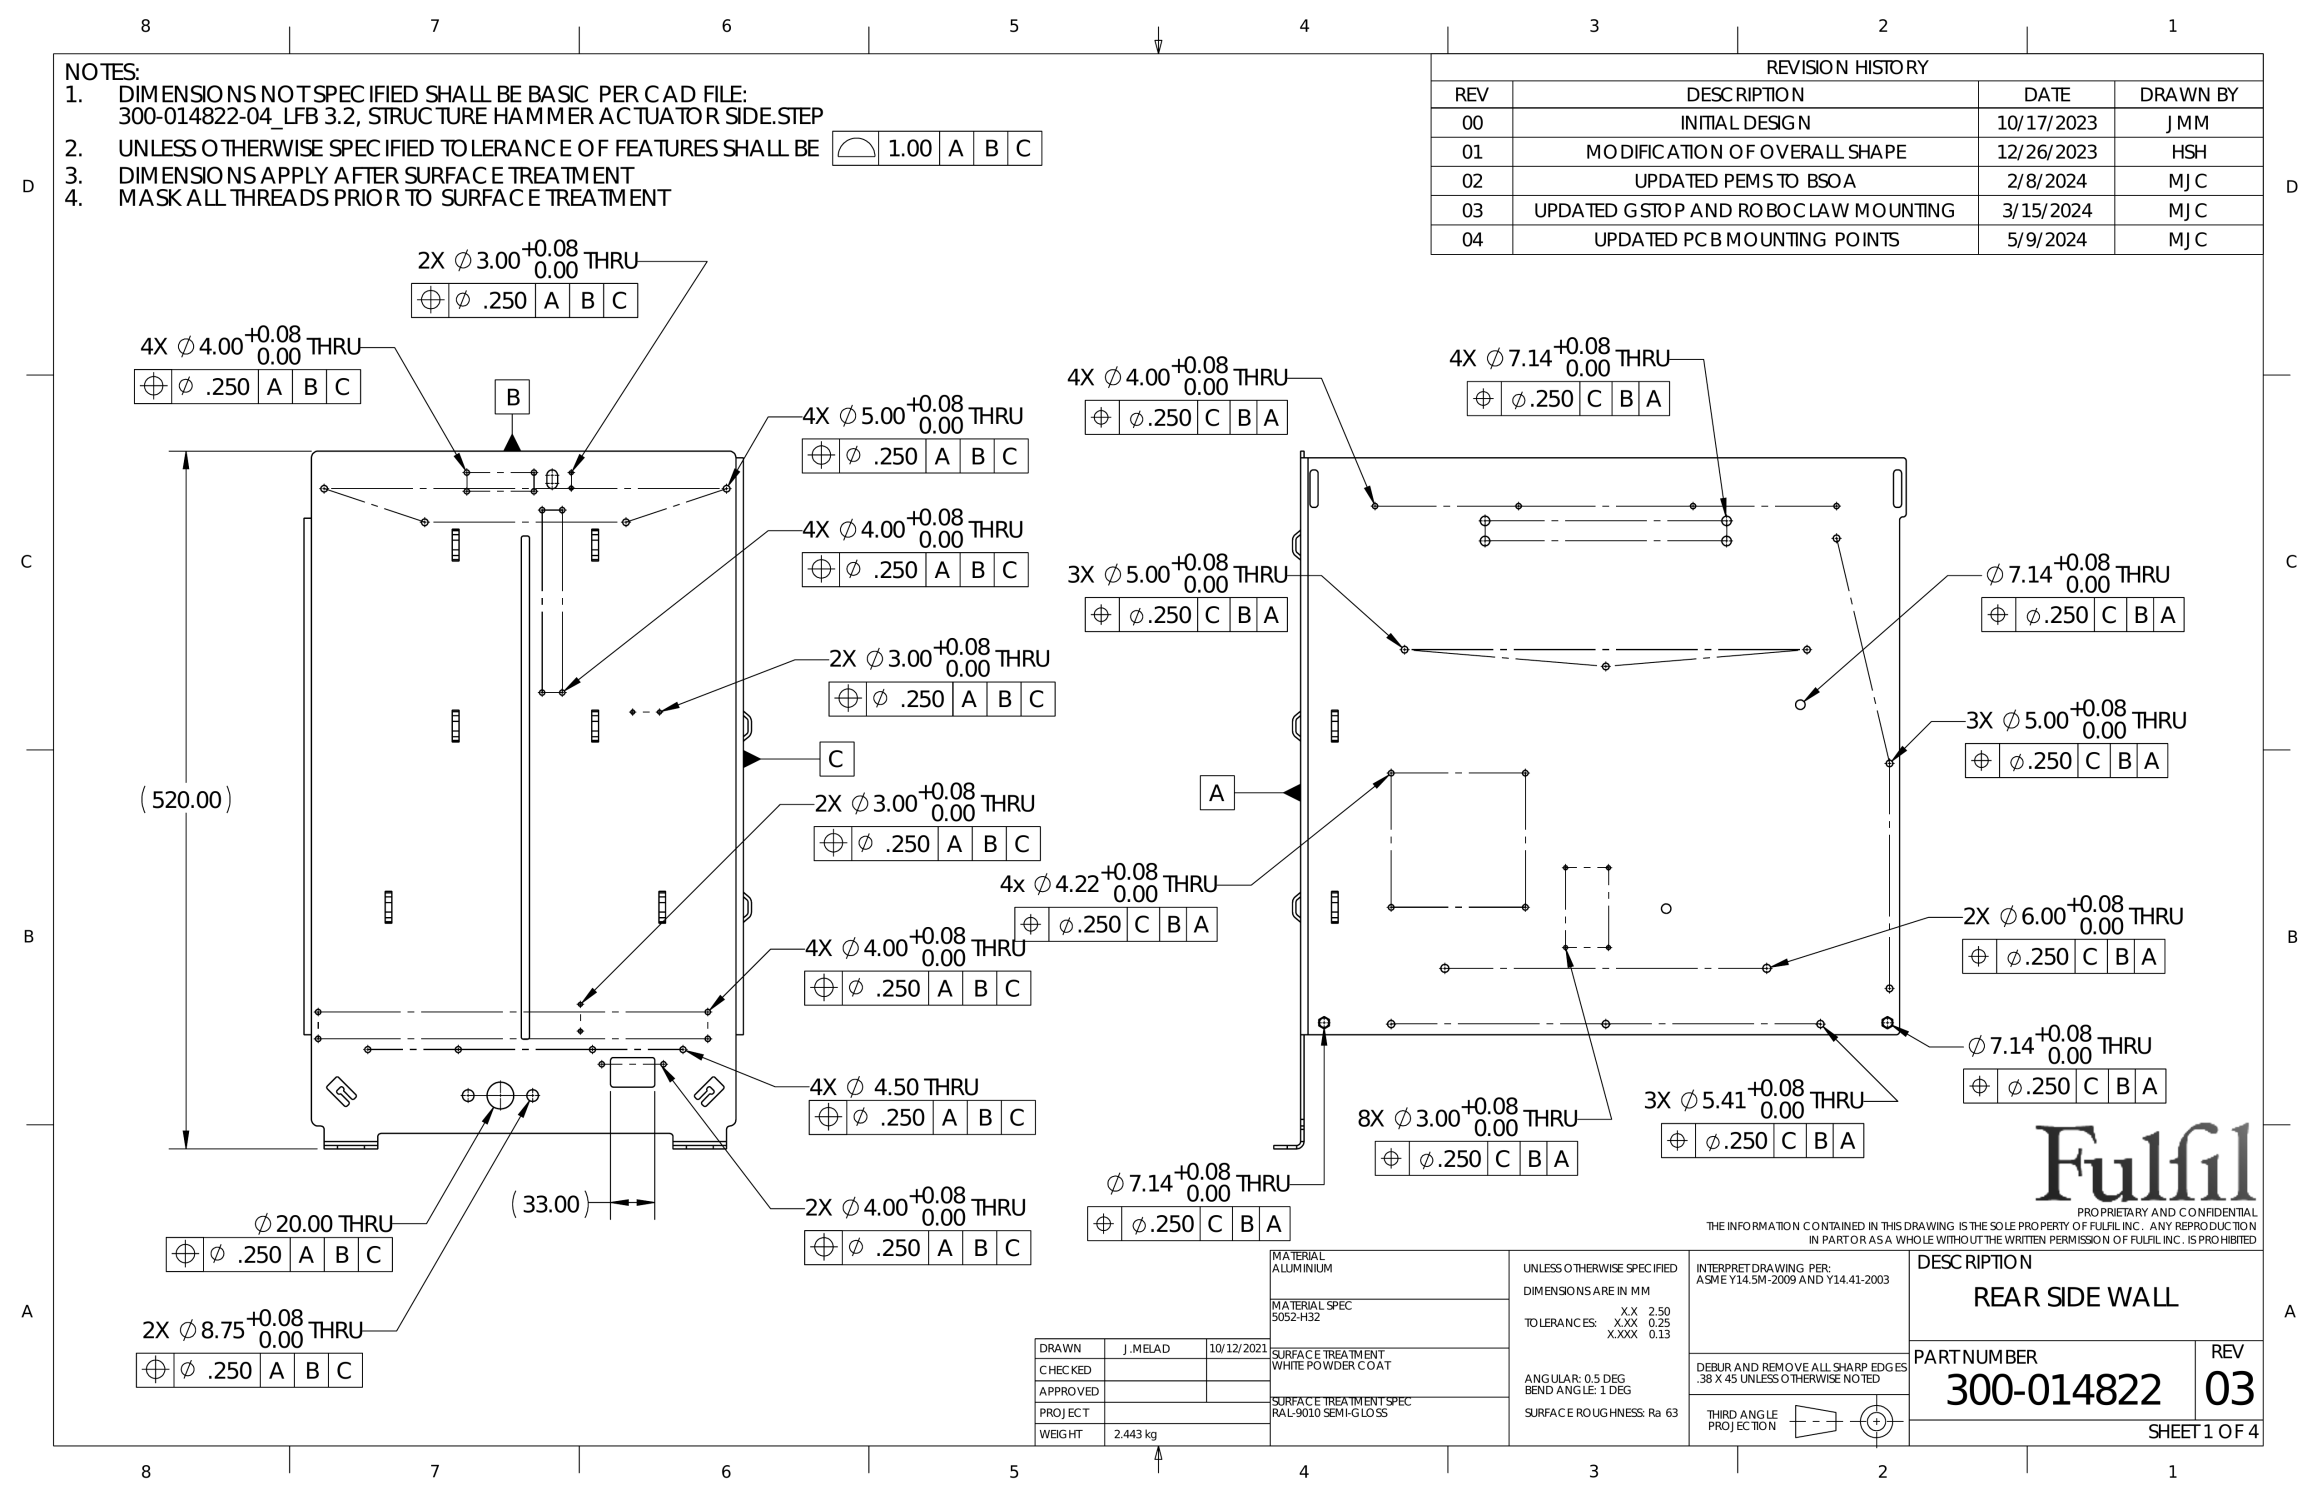

In [1]:
from glob import glob
import os

import cv2
import numpy as np
from PIL import Image
from pdf2image import convert_from_path
from imutils import resize
from pygments.lexer import words
from sklearn.metrics import euclidean_distances
from tqdm import tqdm
from scoring import *
from border_and_title import *

# f = "../../data/original/Ugly/10.pdf"
# f = "../../data/original/Ugly/2.pdf"
# f = "../../data/original/Ugly/000.895.652.pdf"
# f = "../../data/original/Good/300-014823.pdf"
f = "../../data/original/Good/300-014822.pdf"

font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 1
color = (255, 0, 0)
thickness = 2

pages = convert_from_path(f, dpi=300)
img = np.array(pages[0])
img = im_resize(img)
img_comp = img.copy()

Image.fromarray(img_comp)

In [3]:
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 1
color = (255, 0, 0)
thickness = 2

im_h, im_w, _ = img.shape

sorted_indices, contours, hierarchy_area = detect_objects(img)
border_1, border_2 = detect_borders(contours, sorted_indices, words=words)
x, y, w, h = border_2
cv2.rectangle(img_comp, (x, y), (x + w, y + h), (0, 255, 0), 10)
x_1, y_1, w_1, h_1 = border_1
cv2.rectangle(img_comp, (x_1, y_1), (x_1 + w_1, y_1 + h_1), (0, 255, 0), 10)

contours, line_90, ocr_result, mask_comp, mask = detect_probable_title_sections(img, return_states=True)

Image.fromarray(mask)

NameError: name 'words' is not defined

In [ ]:
straight_lines = cv2.HoughLinesP(mask, 1, np.pi / 180, 15, np.array([]), 50, 10)
straight_lines = straight_lines.squeeze(axis=1)

straight_lines

In [ ]:
import pandas as pd

df = pd.DataFrame.from_dict(ocr_result.export())
pages = df.join(pd.json_normalize(df.pop('pages')))
blocks = pages.explode("blocks")
blocks['block_idx'] = np.arange(blocks.shape[0])
blocks['index'] = blocks['block_idx']
blocks = blocks.set_index('index')

blocks = blocks.join(pd.json_normalize(blocks.pop('blocks')))
blocks = blocks.rename(columns={'geometry': 'block_geometry'})
lines = blocks.explode("lines")
lines['line_idx'] = np.arange(lines.shape[0])
lines['index'] = np.arange(lines.shape[0])
lines = lines.set_index('index')
lines = lines.join(pd.json_normalize(lines.pop('lines')), lsuffix='.lines')
lines = lines.rename(columns={'geometry': 'line_geometry'})
words = lines.explode("words")
words['word_idx'] = np.arange(words.shape[0])
words['index'] = np.arange(words.shape[0])
words = words.set_index('index')

words = words.join(pd.json_normalize(words.pop('words')), lsuffix='.words')
words = words.rename(columns={'geometry': 'word_geometry'})

words = words.dropna(subset=['word_geometry'])
words["word_geometry"] = words.word_geometry.apply(
    lambda x: {"x1": x[0][0], "y1": x[0][1], "x2": x[1][0], "y2": x[1][1]}
)
words = words.join(pd.json_normalize(words.pop('word_geometry')))

words["x1"] = words["x1"] * im_w
words["x2"] = words["x2"] * im_w
words["y1"] = words["y1"] * im_h
words["y2"] = words["y2"] * im_h

words

In [ ]:
lines.shape, words.shape

In [ ]:
horizontal_lines = []
vertical_lines = []

for (x1, y1, x2, y2) in straight_lines:
    if abs(y1-y2) <= 5:
        horizontal_lines.append((x1, y1, x2, y2))
    elif abs(x1-x2) <= 5:
        vertical_lines.append((x1, y1, x2, y2))

horizontal_lines = np.array(horizontal_lines)
vertical_lines = np.array(vertical_lines)

horizontal_lines.shape, vertical_lines.shape

In [ ]:
img_comp = img.copy()

for line in horizontal_lines:
    x1, y1, x2, y2 = line
    cv2.line(img_comp, (x1,y1), (x2,y2), (0, 0, 255), 5)

Image.fromarray(img_comp)

In [ ]:
img_comp = img.copy()

for line in vertical_lines:
    x1, y1, x2, y2 = line
    cv2.line(img_comp, (x1,y1), (x2,y2), (0, 0, 255), 5)

Image.fromarray(img_comp)

In [ ]:
# 305 1313 371 1345
# 1269 1306 1323 1326
# 1520 1308 1601 1333
# 1604 1317 1644 1345
# 1617 1302 1644 1326
# 1644 1306 1658 1320
# 1644 1322 1674 1340
# 1656 1304 1674 1322
# 2283 1302 2296 1317
# 251 1320 309 1356

# bx1, by1, bx2, by2 = 1644, 1322, 1674, 1340
# bx1, by1, bx2, by2 = 2283, 1302, 2296, 1317
bx1, by1, bx2, by2 = 1617, 1302, 1644, 1326

t_dist = 600

# Top
candidates = horizontal_lines[(horizontal_lines[:, 1] < by1) & (horizontal_lines[:, 1] > (by1 - t_dist)) & (horizontal_lines[:, 0] < bx1) & (horizontal_lines[:, 2] > bx2)]
candidate = candidates[candidates[:, 0].argmin()]

# # Bottom
# candidates = horizontal_lines[(horizontal_lines[:, 1] > by1) & (horizontal_lines[:, 1] < (by1 + t_dist)) & (horizontal_lines[:, 0] < bx1) & (horizontal_lines[:, 2] > bx2)]
# candidate = candidates[candidates[:, 0].argmax()]

# # Right
# candidates = vertical_lines[(vertical_lines[:, 0] > bx1) & (vertical_lines[:, 0] < (bx1 + t_dist)) & (vertical_lines[:, 1] > by1) & (vertical_lines[:, 3] < by2)]
# candidate = candidates[candidates[:, 0].argmin()]

# # Left
# candidates = vertical_lines[(vertical_lines[:, 0] < bx1) & (vertical_lines[:, 0] > (bx1 - t_dist)) & (vertical_lines[:, 1] > by1) & (vertical_lines[:, 3] < by2)]
# candidate = candidates[candidates[:, 0].argmax()]

img_comp = img.copy()

cv2.rectangle(img_comp, (bx1, by1), (bx2, by2), (0, 0, 255), 5)

for c in candidates:
    x1, y1, x2, y2 = c
    cv2.line(img_comp, (x1,y1), (x2,y2), (0, 255, 0) , 2)

x1, y1, x2, y2 = candidate
cv2.line(img_comp, (x1,y1), (x2,y2), (255, 0, 0) , 5)

Image.fromarray(img_comp)

In [ ]:
def find_closest_lines(bx1, by1, bx2, by2, horizontal_lines, vertical_lines, t_dist=200):
    top = horizontal_lines[(horizontal_lines[:, 1] < by1) & (horizontal_lines[:, 1] > (by1 - t_dist)) & (horizontal_lines[:, 0] < bx1) & (horizontal_lines[:, 2] > bx2)]
    top = top[top[:, 0].argmin()]

    bottom = horizontal_lines[(horizontal_lines[:, 1] > by1) & (horizontal_lines[:, 1] < (by1 + t_dist)) & (horizontal_lines[:, 0] < bx1) & (horizontal_lines[:, 2] > bx2)]
    bottom = bottom[bottom[:, 0].argmax()]

    right = vertical_lines[(vertical_lines[:, 0] > bx1) & (vertical_lines[:, 0] < (bx1 + t_dist)) & (vertical_lines[:, 1] > by1) & (vertical_lines[:, 3] < by2)]
    right = right[right[:, 0].argmin()]

    left = vertical_lines[(vertical_lines[:, 0] < bx1) & (vertical_lines[:, 0] > (bx1 - t_dist)) & (vertical_lines[:, 1] > by1) & (vertical_lines[:, 3] < by2)]
    left = left[left[:, 0].argmax()]

    return np.array([top, bottom, right, left])



bx1, by1, bx2, by2 = 1617, 1302, 1644, 1326
closest = find_closest_lines(bx1, by1, bx2, by2, horizontal_lines, vertical_lines, t_dist=200)
img_comp = img.copy()

cv2.rectangle(img_comp, (bx1, by1), (bx2, by2), (0, 0, 255), 5)

for c in closest:
    x1, y1, x2, y2 = c
    cv2.line(img_comp, (x1,y1), (x2,y2), (0, 255, 0) , 2)

Image.fromarray(img_comp)

In [ ]:
from scipy.spatial import distance


def get_closest_line(ref_lines, threshold=50):
    try:
        distances = distance.cdist([row[["x1", "y1", "x2", "y2"]].astype(int)], ref_lines, "euclidean")[0]
        line_idx = distances.argmin()

        if np.sqrt(distances[line_idx]) < threshold:
            return line_idx
    except ValueError:
        pass

    return None

In [ ]:
img_comp = img.copy()

new_mask = np.zeros_like(img_comp)
done = []
sides = ["top", "bottom", "left", "right"]


for idx, row in words.iterrows():
    bx1, by1, bx2, by2 = row[["x1", "y1", "x2", "y2"]].astype(int)

    try:
        closest = find_closest_lines(bx1, by1, bx2, by2, horizontal_lines, vertical_lines, t_dist=200)
        for c in closest:
            x1, y1, x2, y2 = c
            cv2.line(img_comp, (x1,y1), (x2,y2), (0, 255, 0) , 2)
            cv2.line(new_mask, (x1,y1), (x2,y2), (255, 255, 255) , 2)

        cv2.rectangle(img_comp, (bx1, by1), (bx2, by2), (0, 0, 255), 5)
        cv2.rectangle(new_mask, (bx1, by1), (bx2, by2), (255, 255, 255), cv2.FILLED)
    except ValueError:
        pass

Image.fromarray(img_comp)

In [ ]:
mask_comp = cv2.dilate(new_mask, np.ones((6, 6), np.uint8), iterations=5)
mask_comp = cv2.erode(mask_comp, np.ones((7, 7), np.uint8), iterations=5)
mask_comp = cv2.dilate(mask_comp, np.ones((5, 5), np.uint8), iterations=3)

Image.fromarray(np.hstack((img_comp, mask_comp)))

In [ ]:
gray = cv2.cvtColor(mask_comp, cv2.COLOR_BGR2GRAY)
_, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))
img_comp = mask_comp.copy()

for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = w / float(h)
    area = w * h

    if area > 5000 and (1.3 < aspect_ratio < 10):
        print((x, y), (x + w, y + h))
        cv2.rectangle(img_comp, (x, y), (x + w, y + h), (255, 0, 0), 2)

Image.fromarray(img_comp)

In [ ]:
def bb_ratio_chars_digits(bb, words):
    (cx1, cy1), (cx2, cy2) = bb
    words_in_bb = words.loc[(words.x1 > cx1) & (words.x2 < cx2) & (words.y1 > cy1) & (words.y2 < cy2)]
    sentence = "".join(words_in_bb.value.tolist())
    chars = sum(c.isalpha() for c in sentence)
    digits = sum(c.isdigit() for c in sentence)

    return digits / chars


img_comp = img.copy()

for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = w / float(h)
    area = w * h

    if area > 5000 and (1.3 < aspect_ratio < 10):
        (cx1, cy1), (cx2, cy2) = (x, y), (x + w, y + h)
        ratio = bb_ratio_chars_digits(((x, y), (x + w, y + h)), words)

        cv2.rectangle(img_comp, (cx1, cy1), (cx2, cy2), (255, 0, 0), 2)

        cv2.putText(img_comp, f"{ratio:.2f}", (cx1, cy1), font, fontScale, color, thickness)


Image.fromarray(img_comp)